In [26]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%load_ext autotime

import warnings
warnings.filterwarnings('ignore')

from ngram import *
from baselines import *
from error_analysis import *
from deep_learning import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 4.84 ms


### Load Annotated Data

In [2]:
task = 'recipient'
xtype = 'ngams'
ytype = 'empirical_dist'
n_classes = 2
annotations = load_annotations()

time: 26.3 s


In [3]:
data = label_and_split(annotations, task)

time: 1min 53s


### NGram Preprocessing

In [27]:
maxlen = 100
max_features = 10000
    
feature_pipeline =  Pipeline([
    ('vect', CountVectorizer(ngram_range = (1,1), analyzer = 'word', max_features = max_features)),
    ('to_sequence', SequenceTransformer(maxlen = maxlen)), 
])

X_comments, _ = assemble_data(data, 'comments', ytype, splits = ['train'])
preprocessor = feature_pipeline.fit(X_comments)
data = apply_transform(data, 'comments', preprocessor, xtype)

X_train, y_train = assemble_data(data, xtype, ytype, splits = ['train'])
X_test, y_test = assemble_data(data, xtype, 'empirical_dist', splits = ['test'])

time: 29.4 s


### Define Model

In [28]:
clf =  KerasClassifier(build_fn=make_conv_rnn, output_dim = n_classes, max_features = max_features, maxlen = maxlen)

time: 1.22 ms


### Hyper-Parameter tuning

In [30]:
# Deep EDP

param_grid = {
    'nb_epoch' : (1,2),
    'batch_size': (100,),
    'dropout': (0.25, 0.5)
}

tune (X_train, y_train, clf, param_grid, roc_scorer, n_jobs=1, verbose=True)

Epoch 1/1
30341/30341 [==============================] - 28s    
Epoch 1/2
70793/70793 [==============================] - 244s - loss: 0.0680 - acc: 0.9520   
Epoch 2/2
30341/30341 [==============================] - 30s    
Epoch 1/1
30341/30341 [==============================] - 33s    
Epoch 1/2
70793/70793 [==============================] - 328s - loss: 0.0716 - acc: 0.9490   
Epoch 2/2
30341/30341 [==============================] - 30s    

Best parameters set found:
{'nb_epoch': 2, 'dropout': 0.25, 'batch_size': 100} 0.972344856198


Grid scores:
0.96992 (+/-0.00000) for {'nb_epoch': 1, 'dropout': 0.25, 'batch_size': 100}
0.97234 (+/-0.00000) for {'nb_epoch': 2, 'dropout': 0.25, 'batch_size': 100}
0.96751 (+/-0.00000) for {'nb_epoch': 1, 'dropout': 0.5, 'batch_size': 100}
0.97080 (+/-0.00000) for {'nb_epoch': 2, 'dropout': 0.5, 'batch_size': 100}
time: 31min 59s


Seems, like we don't need to regularize at one epoch. Lets try more epochs.

### Eval SKlearn

In [6]:
sk_model = LogisticRegression(C = 5.0,  solver = 'sag')
sk_model.fit(X_train, y_train.argmax(axis = 1))
roc_df, spearman_df = test_cross(sk_model, data, xtype)

time: 2min 54s


In [7]:
roc_df

,random,blocked,both
user,0.987031,0.952511,0.962879
article,0.988195,0.963257,0.971912
both,0.987903,0.961307,0.970488


time: 8.42 ms


In [8]:
spearman_df

,random,blocked,both
user,0.205761,0.651672,0.603383
article,0.162326,0.419992,0.346429
both,0.174843,0.616330,0.541410


time: 9.65 ms


### Eval Conv RNN

In [32]:
conv_rnn =  KerasClassifier(build_fn=make_conv_rnn,
                            output_dim = n_classes,
                            max_features = max_features,
                            maxlen = maxlen,
                            batch_size = 100,
                            nb_epoch = 2,
                            dropout = 0.25)
conv_rnn.fit(X_train, y_train)
roc_df, spearman_df = test_cross(conv_rnn, data, xtype)

Epoch 1/2
101134/101134 [==============================] - 312s - loss: 0.0621 - acc: 0.9545   
Epoch 2/2
25285/25285 [==============================] - 23s    
time: 13min 37s


In [35]:
roc_df

,random,blocked,both
user,0.971240,0.953340,0.964069
article,0.991404,0.967789,0.976519
both,0.980668,0.962592,0.972059


time: 7.51 ms


In [36]:
spearman_df

,random,blocked,both
user,0.258598,0.688111,0.655399
article,0.178419,0.482818,0.395979
both,0.204726,0.664377,0.594611


time: 5.61 ms


### Check Calibration

25285/25285 [==============================] - 23s    


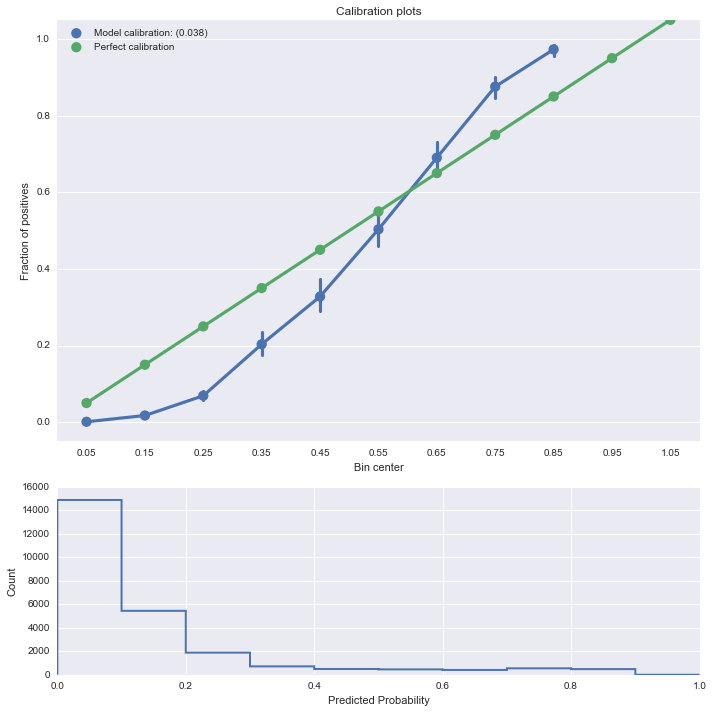

time: 24.8 s


In [37]:
y_test_oh = one_hot(y_test)
y_pred_ed = conv_rnn.predict_proba(X_test)

if n_classes > 2:
    classes = range(n_classes)
else:
    classes = [1]

for i in classes:
    plt.figure()
    calibration_curve_plotter(y_test_oh[:, i], y_pred_ed[:, i])
    plt.show()